In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from reduce_mem_usage import reduce_mem_usage

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

from joblib import Parallel, delayed

pd.set_option("display.max_columns", 101)

In [2]:
# Credit: The reduce_mem_usage function has been taken from 
# https://gist.github.com/tkazusa/4d9e26d403c73755edc6b77b5b053a43
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type)!= 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
unpickled_df = pd.read_pickle("./data.pkl")
unpickled_df.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,day_number,units_sold,date,weekday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week
59181085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,NaN,2016-05-22,Sunday,5,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469,20
59181086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,NaN,2016-05-22,Sunday,5,2016,NaN,NaN,NaN,NaN,0,0,0,2.480469,20
59181087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,NaN,2016-05-22,Sunday,5,2016,NaN,NaN,NaN,NaN,0,0,0,3.980469,20
59181088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,NaN,2016-05-22,Sunday,5,2016,NaN,NaN,NaN,NaN,0,0,0,1.280273,20
59181089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1941,NaN,2016-05-22,Sunday,5,2016,NaN,NaN,NaN,NaN,0,0,0,1.000000,20


In [4]:
unique_dept_ids = unpickled_df.dept_id.unique().to_list()
print(len(unique_dept_ids))
unique_dept_ids

7


['HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2',
 'FOODS_1',
 'FOODS_2',
 'FOODS_3']

In [5]:
unpickled_df.dept_id.value_counts()

FOODS_3        15974430
HOUSEHOLD_1    10326120
HOUSEHOLD_2     9996150
HOBBIES_1       8074560
FOODS_2         7725180
FOODS_1         4192560
HOBBIES_2       2892090
Name: dept_id, dtype: int64

In [6]:
unpickled_df.cat_id.value_counts()

FOODS        27892170
HOUSEHOLD    20322270
HOBBIES      10966650
Name: cat_id, dtype: int64

In [7]:
le = preprocessing.LabelEncoder()
le.fit_transform(unpickled_df.item_id)

array([1437, 1438, 1439, ..., 1434, 1435, 1436])

In [8]:
# Otherwise label encoding will give an error
unpickled_df['event_type_1'] = unpickled_df['event_type_1'].cat.add_categories('Unknown')
unpickled_df['event_type_2'] = unpickled_df['event_type_2'].cat.add_categories('Unknown')
unpickled_df['event_name_1'] = unpickled_df['event_name_1'].cat.add_categories('Unknown')
unpickled_df['event_name_2'] = unpickled_df['event_name_2'].cat.add_categories('Unknown')

unpickled_df['event_type_1'].fillna('Unknown', inplace=True)
unpickled_df['event_type_2'].fillna('Unknown', inplace=True)
unpickled_df['event_name_1'].fillna('Unknown', inplace=True)
unpickled_df['event_name_2'].fillna('Unknown', inplace=True)

unpickled_df['event_type_1'].value_counts()

Unknown      54363670
Religious     1646460
National      1554990
Cultural      1128130
Sporting       487840
Name: event_type_1, dtype: int64

In [9]:
leitem_id = preprocessing.LabelEncoder()
leitem_id.fit(unpickled_df.item_id)

lestore_id = preprocessing.LabelEncoder()
lestore_id.fit(unpickled_df.store_id)

leweekday = preprocessing.LabelEncoder()
leweekday.fit(unpickled_df.weekday)

leevent_type_1 = preprocessing.LabelEncoder()
leevent_type_1.fit(unpickled_df.event_type_1)

leevent_type_2 = preprocessing.LabelEncoder()
leevent_type_2.fit(unpickled_df.event_type_2)

leevent_name_1 = preprocessing.LabelEncoder()
leevent_name_1.fit(unpickled_df.event_name_1)

leevent_name_2 = preprocessing.LabelEncoder()
leevent_name_2.fit(unpickled_df.event_name_2)

LabelEncoder()

In [11]:
# In order to be able to get names of stores and items again
np.save('item_ids_encoded', leitem_id.classes_)

In [13]:
np.save('store_ids_encoded', lestore_id.classes_)

In [6]:
leevent_name_2.classes_

array(['Cinco De Mayo', 'Easter', "Father's day", 'OrthodoxEaster',
       'Unknown'], dtype=object)

In [8]:
def snap(row):
    if row['snap_'+ row.state_id] == 1:
        return 1
    return 0

def dept_feature_generation(deptid):
    dept_data = unpickled_df.loc[unpickled_df.dept_id == deptid].copy()
    dept_data['snap'] = dept_data.apply(snap, axis=1)
    dept_data.drop(['snap_CA', 'snap_WI', 'snap_TX'], axis=1, inplace=True)
    
    dept_data.drop(['cat_id', 'state_id', 'date', 'year'], axis=1, inplace=True)
    dept_data['units_lag_28'] = dept_data.groupby('id')['units_sold'].transform(
        lambda x: x.shift(28, fill_value=0)
    )
    
    print('Starting column generation....')

    # https://pbpython.com/pandas_transform.html
    # Rolling units sold for days -28 to -34
    dept_data['mean_rolling_7'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -55
    dept_data['mean_rolling_28'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).mean()
    )
    # Rolling units sold for days -28 to -76
    dept_data['mean_rolling_49'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).mean()
    )
    dept_data['mean_rolling_84'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).mean()
    )
    dept_data['mean_rolling_140'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).mean()
    )
    
    dept_data['std_rolling_7'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    dept_data['std_rolling_28'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    dept_data['std_rolling_49'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(49, min_periods=1).std()
    )
    dept_data['std_rolling_84'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(84, min_periods=1).std()
    )
    dept_data['std_rolling_140'] = dept_data.groupby('id')['units_lag_28'].transform(
        lambda x: x.rolling(140, min_periods=1).std()
    )
    
    dept_data['std_price_rolling_7'] = dept_data.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )
    dept_data['std_price_rolling_28'] = dept_data.groupby('id')['sell_price'].transform(
        lambda x: x.rolling(28, min_periods=1).std()
    )
    dept_data['price_percent_change'] = dept_data.groupby('id')['sell_price'].pct_change()
    
    print('Generated columns')
    dept_data.drop('id', axis=1, inplace=True)
    dept_data.reset_index(drop=True, inplace=True)
    
    dept_data['item_id'] = leitem_id.transform(dept_data.item_id)
    dept_data['store_id'] = lestore_id.transform(dept_data['store_id'])
    dept_data['weekday'] =  leweekday.transform(dept_data['weekday'])
    dept_data['event_name_1'] = leevent_name_1.transform(dept_data['event_name_1'])
    dept_data['event_name_2'] = leevent_name_2.transform(dept_data['event_name_2'])
    dept_data['event_type_1'] = leevent_type_1.transform(dept_data['event_type_1'])
    dept_data['event_type_2'] = leevent_type_2.transform(dept_data['event_type_2'])
    
    print('Label encoding complete')
    # Keep only non-zero rolling value rows
    dept_data = dept_data[dept_data.day_number.astype(int) > 1000]
    
    return dept_data

In [9]:
dept_hobbies_2 = dept_feature_generation('HOBBIES_2')
dept_hobbies_2.head()

Starting column generation....
Generated columns
Label encoding complete


,item_id,dept_id,store_id,day_number,units_sold,weekday,month,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,week,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change
1490000,1853,HOBBIES_2,0,1001,0.0,0,10,28,4,4,2,5.968750,43,0,0.0,0.000000,0.142822,0.102051,0.083313,0.078552,0.000000,0.356445,0.305908,0.278076,0.295410,5.960464e-08,0.0,0.0
1490001,1854,HOBBIES_2,0,1001,1.0,0,10,28,4,4,2,1.969727,43,0,0.0,0.142822,0.142822,0.163208,0.095215,0.135742,0.377930,0.448486,0.471924,0.367920,0.436035,0.000000e+00,0.0,0.0
1490002,1855,HOBBIES_2,0,1001,1.0,0,10,28,4,4,2,1.969727,43,0,1.0,0.142822,0.142822,0.081604,0.047607,0.042847,0.377930,0.448486,0.343750,0.264648,0.235962,0.000000e+00,0.0,0.0
1490003,1856,HOBBIES_2,0,1001,0.0,0,10,28,4,4,2,2.470703,43,0,0.0,0.428467,0.107117,0.163208,0.095215,0.057129,1.133789,0.566895,0.717285,0.551270,0.428711,0.000000e+00,0.0,0.0
1490004,1857,HOBBIES_2,0,1001,0.0,0,10,28,4,4,2,4.468750,43,0,1.0,0.285645,0.285645,0.244873,0.178589,0.164307,0.488037,0.459961,0.479980,0.415283,0.408691,0.000000e+00,0.0,0.0


In [13]:
dept_hobbies_2.tail()

,item_id,dept_id,store_id,day_number,units_sold,weekday,month,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,week,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change
2892085,1997,HOBBIES_2,9,1941,NaN,3,5,28,4,4,2,2.880859,20,0,0.0,0.571289,0.535645,0.510254,0.452393,0.350098,1.511719e+00,1.036133,1.002930,0.870117,0.748535,0.0,0.0,0.0
2892086,1998,HOBBIES_2,9,1941,NaN,3,5,28,4,4,2,1.969727,20,0,0.0,0.000000,0.071411,0.142822,0.107117,0.085693,0.000000e+00,0.262207,0.408203,0.347656,0.305420,0.0,0.0,0.0
2892087,1999,HOBBIES_2,9,1941,NaN,3,5,28,4,4,2,0.970215,20,0,0.0,0.714355,0.821289,0.734863,0.678711,0.664062,9.511719e-01,1.188477,1.076172,1.110352,1.226562,0.0,0.0,0.0
2892088,2000,HOBBIES_2,9,1941,NaN,3,5,28,4,4,2,0.879883,20,0,0.0,0.000000,0.285645,0.285645,0.309570,0.364258,5.960464e-08,0.854492,0.763672,0.693848,0.797363,0.0,0.0,0.0
2892089,2001,HOBBIES_2,9,1941,NaN,3,5,28,4,4,2,0.970215,20,0,0.0,0.285645,0.142822,0.224487,0.357178,0.414307,7.558594e-01,0.448486,0.621094,0.722168,0.768066,0.0,0.0,0.0


In [10]:
dept_hobbies_2 = reduce_mem_usage(dept_hobbies_2)

Memory usage of dataframe is 155.12 MB
Memory usage after optimization is: 72.22 MB
Decreased by 53.4%


In [31]:
dept_hobbies_2.to_pickle("./dept_hobbies_2.pkl")

## Try XGBoost

In [11]:
# because day_number is not a feature, and we want to add columns after units_sold also
indices_list = [2]
for i in range(5, dept_hobbies_2.shape[1]):
    indices_list.append(i)
indices_list

[2,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27]

In [12]:
dept_hobbies_2_train = dept_hobbies_2[dept_hobbies_2.day_number.astype(int) <= 1885].reset_index(drop=True) # 1913-28
dept_hobbies_2_validation = dept_hobbies_2[(dept_hobbies_2.day_number.astype(int) > 1885)
                                         & (dept_hobbies_2.day_number.astype(int) < 1914)].reset_index(drop=True)
dept_hobbies_2_test = dept_hobbies_2[dept_hobbies_2.day_number.astype(int) >= 1914].reset_index(drop=True)

dept_hobbies_2_train_x = dept_hobbies_2_train.iloc[:, indices_list]
dept_hobbies_2_train_y = dept_hobbies_2_train.units_sold
dept_hobbies_2_validation_x = dept_hobbies_2_validation.iloc[:, indices_list]
dept_hobbies_2_validation_y = dept_hobbies_2_validation.units_sold

dept_hobbies_2_test_x = dept_hobbies_2_test.iloc[:, indices_list]

In [13]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [14]:
model.fit(dept_hobbies_2_train_x, dept_hobbies_2_train_y)

/home/asif/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/asif/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:14:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

In [15]:
xgb_preds = np.round(model.predict(dept_hobbies_2_validation_x))

In [16]:
np.sqrt(mean_squared_error(dept_hobbies_2_validation_y.values, xgb_preds))

0.7939277

Text(0, 0.5, 'Feature Importance Score')

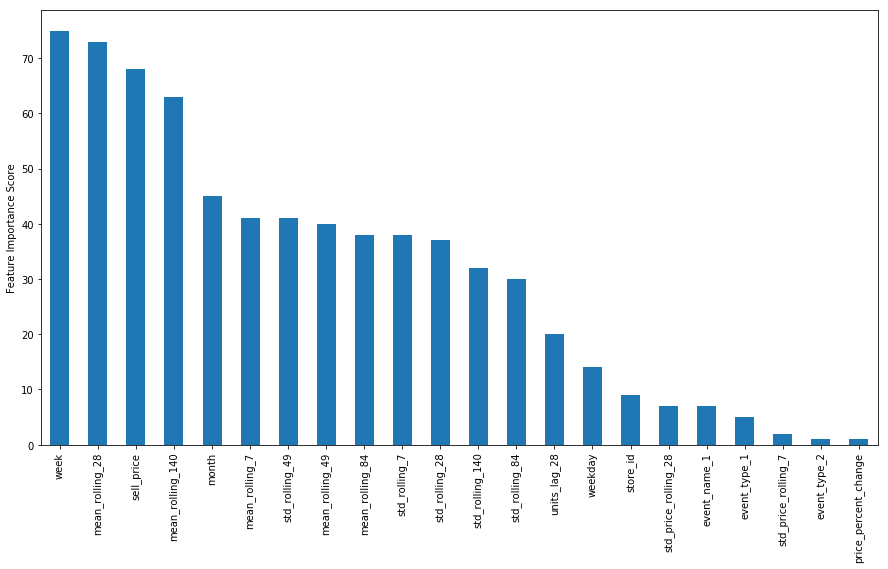

In [17]:
feature_importances = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 8))
feature_importances.plot(kind='bar')

plt.ylabel('Feature Importance Score')

In this model, month and week are important features so it seems to capture seasonality better than the previous model. This is because we've done label encoding - in one-hot encoding those features were being ignored. Label encoding generally brings better results than one-hot encoding in tree-based models.

In [18]:
# Generate for the biggest category
dept_foods_3 = dept_feature_generation('FOODS_3')
dept_foods_3.head()

Starting column generation....
Generated columns
Label encoding complete


,item_id,dept_id,store_id,day_number,units_sold,weekday,month,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,week,snap,units_lag_28,mean_rolling_7,mean_rolling_28,mean_rolling_49,mean_rolling_84,mean_rolling_140,std_rolling_7,std_rolling_28,std_rolling_49,std_rolling_84,std_rolling_140,std_price_rolling_7,std_price_rolling_28,price_percent_change
8230000,614,FOODS_3,0,1001,1.0,0,10,28,4,4,2,2.500000,43,0,1.0,0.142822,0.571289,0.326416,0.190430,0.114258,0.377930,1.730469,1.329102,1.023438,0.796387,0.0,0.0,0.0
8230001,615,FOODS_3,0,1001,4.0,0,10,28,4,4,2,2.500000,43,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8230002,616,FOODS_3,0,1001,0.0,0,10,28,4,4,2,NaN,43,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
8230003,617,FOODS_3,0,1001,0.0,0,10,28,4,4,2,4.269531,43,0,0.0,0.000000,0.250000,0.244873,0.250000,0.228516,0.000000,0.645508,0.630371,0.598633,0.579590,0.0,0.0,0.0
8230004,618,FOODS_3,0,1001,1.0,0,10,28,4,4,2,1.980469,43,0,3.0,1.571289,1.178711,0.856934,0.821289,0.921387,1.397461,1.090820,0.979004,0.983887,1.073242,0.0,0.0,0.0


In [19]:
dept_foods_3_train = dept_foods_3[dept_foods_3.day_number.astype(int) <= 1885].reset_index(drop=True) # 1913-28
dept_foods_3_validation = dept_foods_3[(dept_foods_3.day_number.astype(int) > 1885)
                                         & (dept_foods_3.day_number.astype(int) < 1914)].reset_index(drop=True)
dept_foods_3_test = dept_foods_3[dept_foods_3.day_number.astype(int) >= 1914].reset_index(drop=True)

dept_foods_3_train_x = dept_foods_3_train.iloc[:, indices_list]
dept_foods_3_train_y = dept_foods_3_train.units_sold
dept_foods_3_validation_x = dept_foods_3_validation.iloc[:, indices_list]
dept_foods_3_validation_y = dept_foods_3_validation.units_sold

dept_foods_3_test_x = dept_foods_3_test.iloc[:, indices_list]

model.fit(dept_foods_3_train_x, dept_foods_3_train_y)

/home/asif/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/asif/.local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:59:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:59:53] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

In [20]:
xgb_preds_dept_foods_3 = np.round(model.predict(dept_foods_3_validation_x))
np.sqrt(mean_squared_error(dept_foods_3_validation_y.values, xgb_preds_dept_foods_3))

/home/asif/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


3.2330875

### Carry out feature engineering for each department + Create separate datasets

In [27]:
for dept in unique_dept_ids:
    filename = 'dept_{}'.format(dept.lower())
    dept_feature = dept_feature_generation(dept)
    dept_feature = reduce_mem_usage(dept_feature)
    dept_feature.to_pickle("./{}.pkl".format(filename))

Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 433.07 MB
Memory usage after optimization is: 201.61 MB
Decreased by 53.4%
Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 155.12 MB
Memory usage after optimization is: 72.22 MB
Decreased by 53.4%
Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 553.82 MB
Memory usage after optimization is: 257.82 MB
Decreased by 53.4%
Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 536.13 MB
Memory usage after optimization is: 249.58 MB
Decreased by 53.4%
Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 224.87 MB
Memory usage after optimization is: 104.69 MB
Decreased by 53.4%
Starting column generation....
Generated columns
Label encoding complete
Memory usage of dataframe is 414.33 MB
Memo